In [253]:
import pandas as pd
train = pd.read_feather('Feathers/processed_train_data.feather')
train.head()

,text,label
0,reader mail sc ruling alimony supreme court ex...,0
1,niqaab elephant courtroom say uk judge person ...,0
2,grandparent honoured staff student global publ...,0
3,guardian quick crossword convinced know pay news,0
4,fisherman strike country boat fisherman pamban...,1


In [254]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline

clf1 = LinearSVC(loss='squared_hinge', tol=0.0001, penalty='l2', fit_intercept=True)
clf2 = RandomForestClassifier(n_estimators=200, max_features='sqrt')
clf3 = xgb.XGBClassifier(scale_pos_weight=3, learning_rate=0.2)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df = 0.75)),
    ('tmk', TomekLinks()),
    ('rus', RandomUnderSampler(sampling_strategy = 0.5)),
    ('smt', SMOTE()),
    ('eclf', VotingClassifier(estimators=[('lsv', clf1), ('rf', clf2), ('xgb', clf3)], voting='hard', weights=[1, 1, 2]))
])

parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1_macro')
grid_search.fit(train.text, train.label)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


Best score: 0.836
Best parameters set:
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
	tfidf__use_idf: False


In [255]:
def preProcessing(text):
    import re
    import string
    
    # convert text to lowercase
    out_text = text.lower()
    
    # remove punctuation, numbers and symbols
    out_text = re.sub('[^\sA-Za-z]+', '', out_text)
    
    # remove whitespaces
    out_text = out_text.strip()
    
    # remove stopwords
    from gensim.parsing.preprocessing import STOPWORDS
    stop_words = STOPWORDS.union(set(['mr', 'visakhapatnam', 'rythu', 'p', 'kurmeswara', 'rao']))
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(out_text)
    out_text = [i for i in tokens if not i in stop_words]
    
    # lemmatization
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    result = []
    for word in out_text:
        result.append(lemmatizer.lemmatize(word))
        
    return result

In [256]:
import pandas as pd
test = pd.read_json ('Sabinet_R_no_labels.json', lines=True)
test.head()

,id,url,text
0,5db56b78ee1f2000174633c4,SAPAI-4a5e744d87-52835.txt,The US Supreme Court Monday refused to hear an...
1,5db56b78ee1f2000174633b7,SAP140527S1814.txt,Police are still searching for an East Europea...
2,5db56b78ee1f2000174633ce,SAPANA_20161024074340000_938491.txt,Two sheep thieves in NWest court Molaole Monts...
3,5db56b78ee1f2000174633d6,SAPAI-50e69f849f-87964.txt,A teenager and her younger brother were killed...
4,5db56b78ee1f2000174633df,SAPANA_20180924133013000_7515874.txt,"ANCWL in NWest mourns Molewa, Diswai Molaole M..."


In [257]:
clean_text = []
for text in test.text:
    text = ' '.join(preProcessing(text))
    clean_text.append(text)
    
clean_text[0]

'supreme court monday refused hear appeal horse abattoir forced closure despite claim american horse meat greatly valued europe year horse abattoir united state texas illinois closed state pressure animal right group passed law banning killing horse human consumption illinois slaughterhouse run cavel international affiliate belgian company employed people killed horse year annual revenue million dollar cavel fought ban arguing meat exported europe japan illinois law encroached federal regulation international commerce appeal court rejected cavels argument september saying company failed stopping operation risked affecting global horse meat market monday supreme court declined hear case appeal cavels appeal received backing belgium told court american horse meat considered consumer belgium eu highest quality distinguishable horse meat produced nation sapaafp np'

In [258]:
y_pred = grid_search.predict(clean_text)
test['label'] = y_pred

In [259]:
test.to_csv('bugra_sabinet_results.csv')

In [260]:
test = pd.read_feather('Feathers/processed_test_data.feather')

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       153
           1       0.86      0.86      0.86        50

    accuracy                           0.93       203
   macro avg       0.91      0.91      0.91       203
weighted avg       0.93      0.93      0.93       203



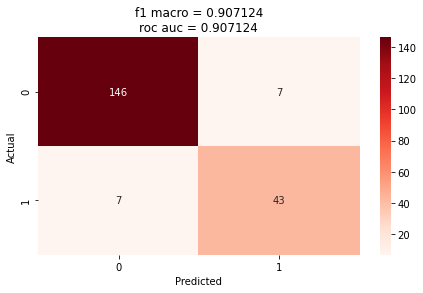

In [261]:
y_pred = grid_search.predict(test.text)
print(classification_report(test.label, y_pred))
conf_matrix = confusion_matrix(test.label, y_pred)
plt.figure(figsize=(7.2,4))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=[0, 1], 
            yticklabels=[0, 1],
            cmap="Reds",)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('f1 macro = %f\nroc auc = %f' %(f1_score(test.label, y_pred, average='macro'), roc_auc_score(test.label, y_pred)))
plt.show()